In [44]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance


In [45]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [46]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [47]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [49]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [50]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [51]:

def extract_and_process_features(file_path, sr=22050):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Log Mel Spectrogram features
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec)
    log_mel_spec_mean = np.mean(log_mel_spec, axis=1)
    
    # Flatten Log Mel Spectrogram for storage or initial processing
    log_mel_spec_flattened = log_mel_spec.flatten()

    # Store the original shape of Log Mel Spectrogram
    original_shape = log_mel_spec.shape

    # Combine MFCC mean and flattened Log Mel Spectrogram
    combined_features = np.concatenate((mfcc_mean, log_mel_spec_flattened))

    return combined_features, original_shape



In [52]:
sr = 22050  
features_list = [extract_and_process_features(fp, sr) for fp in file_paths]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test, files_train, files_test = train_test_split(
    features_list, encoded_labels, file_paths, test_size=0.2, random_state=42
)

Accuracy: 0.8949308755760369
Classification Report:
              precision    recall  f1-score   support

    bewickii       0.89      0.88      0.88       193
  cardinalis       0.87      0.88      0.87       204
     melodia       0.87      0.90      0.88       243
 migratorius       0.92      0.94      0.93       207
 polyglottos       0.93      0.87      0.90       238

    accuracy                           0.89      1085
   macro avg       0.90      0.90      0.89      1085
weighted avg       0.90      0.89      0.89      1085



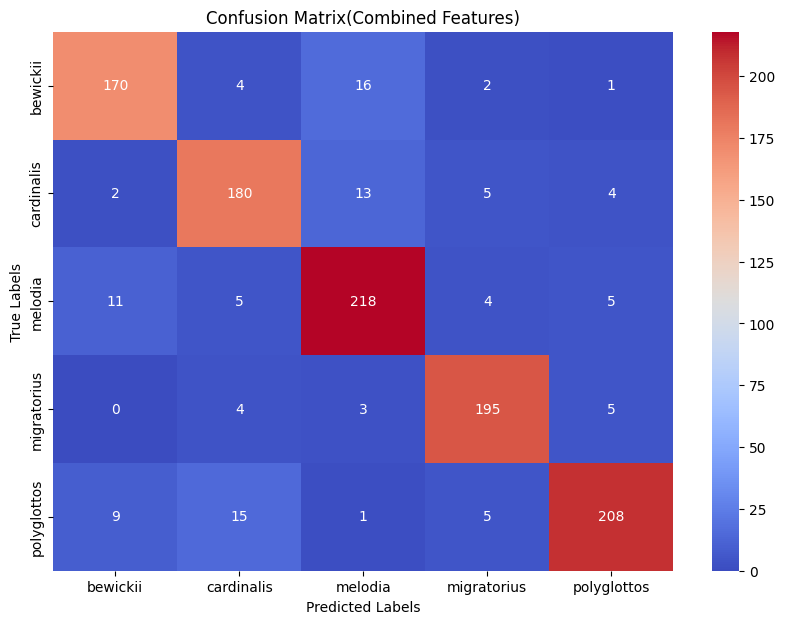

In [58]:

clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X3_train, y3_train)

Combined_predictions = clf_combined.predict(X3_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y3_test, Combined_predictions))
print("Classification Report:")
print(classification_report(y3_test, Combined_predictions, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y3_test, Combined_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel(' True Labels ')
plt.title('Confusion Matrix(Combined Features)')
plt.show()


In [54]:

# Calculate probabilities and find maximum confidence predictions
probs = clf_combined.predict_proba(X3_test)
max_probs = np.max(probs, axis=1)

# Top 10, bottom 10, and incorrect indices
top_10_indices = np.argsort(-max_probs)[:10]
print("top 10 indices:",top_10_indices)
bottom_10_indices = np.argsort(max_probs)[:10]
print("bottom_10_indices:", bottom_10_indices)
incorrect_indices = np.where(Combined_predictions != y3_test)[0]
print("incorrect indices:",incorrect_indices)

top 10 indices: [123 208   7 673 963  36 224 966 854 627]
bottom_10_indices: [ 70 402 476 188 862 987 136 974 689  11]
incorrect indices: [  11   27   50   56   61   64   70   82   93  102  106  114  119  122
  129  136  145  162  176  179  180  188  202  204  205  206  210  221
  235  268  285  287  299  324  334  336  363  364  391  400  401  402
  404  410  413  427  454  455  477  478  486  495  513  543  558  569
  570  572  574  576  579  586  588  622  636  645  650  652  658  662
  680  683  705  713  729  747  750  753  760  762  769  779  788  804
  807  817  825  833  851  862  869  888  893  911  927  931  933  946
  948  962  969  972  974  984  987  993 1038 1049 1051 1060 1066 1068
 1072 1076]


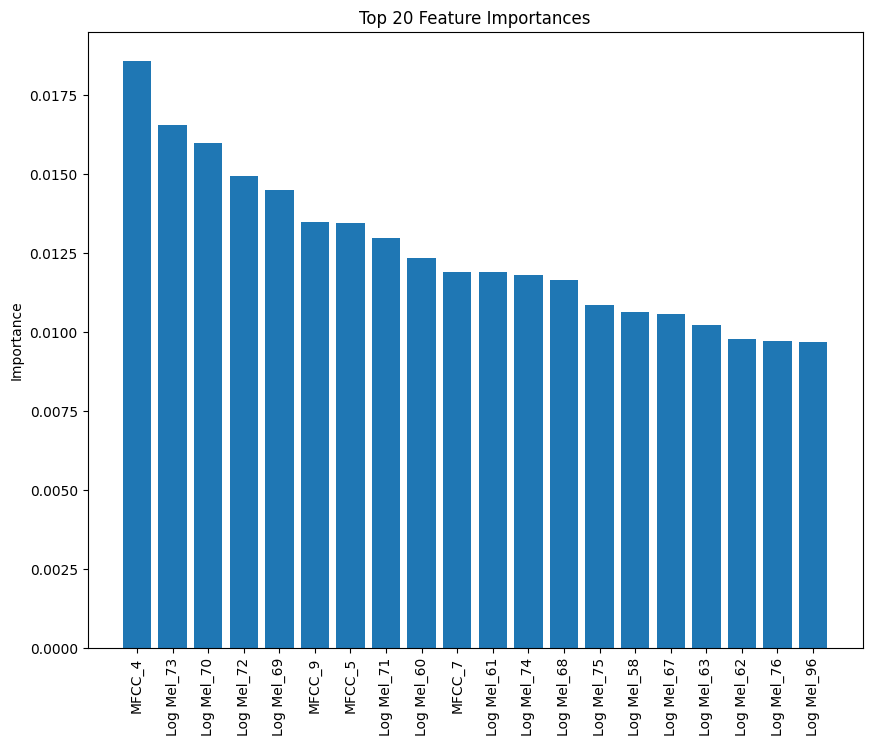

In [55]:

feature_names = ['MFCC_{}'.format(i) for i in range(13)] + \
                ['Log Mel_{}'.format(i) for i in range(128)] 

importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  

# Plotting top N features
N = 20
plt.figure(figsize=(10, 8))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance')
plt.show()


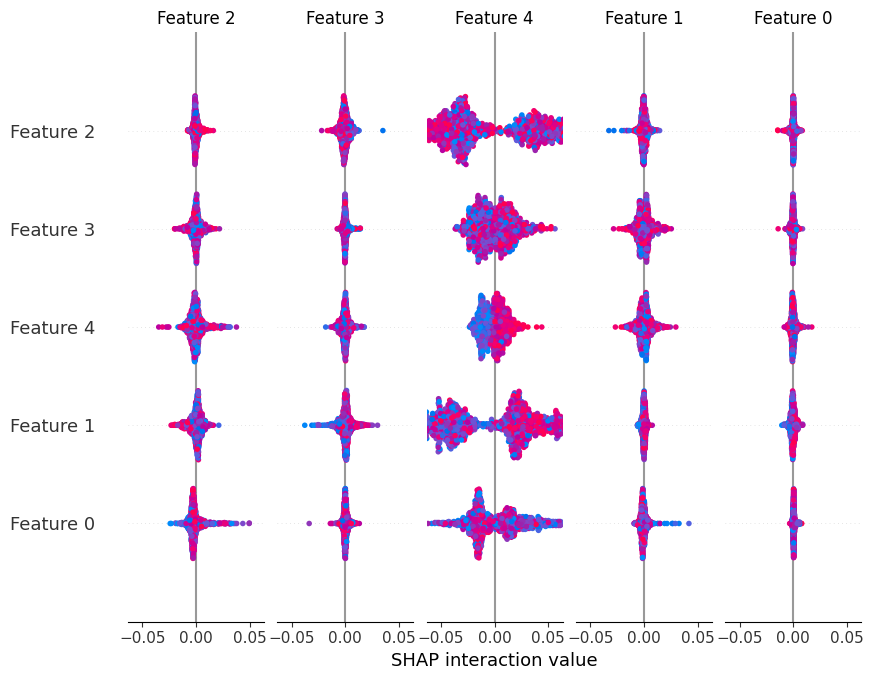

In [59]:

X3_test = np.array(X3_test)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(clf_combined)
shap_values = explainer.shap_values(X3_test)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X3_test)
